In [65]:
# Install required packages
# !pip install wordcloud
# !pip install tensorflow
# !pip install tensorflow-gpu

In [2]:
# import required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from wordcloud import WordCloud

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, fbeta_score, accuracy_score, confusion_matrix, roc_curve, auc, cohen_kappa_score
from sklearn.preprocessing import label_binarize

In [26]:
# Load and clean the data
data = pd.read_csv("train.csv")
data = data.dropna() #< drop rows with missing values

# Extract the features (text) and labels (scores)
X = data.iloc[:, 1]
y = data.iloc[:, 2]

print(X.head())
print()
print(y.head())

# Convert y to integer type
y = y.astype(int)
maxScore = y.max()

0    Many people have car where they live. The thin...
1    I am a scientist at NASA that is discussing th...
2    People always wish they had the same technolog...
3    We all heard about Venus, the planet without a...
4    Dear, State Senator\n\nThis is a letter to arg...
Name: full_text, dtype: object

0    3.0
1    3.0
2    4.0
3    4.0
4    3.0
Name: score, dtype: float64


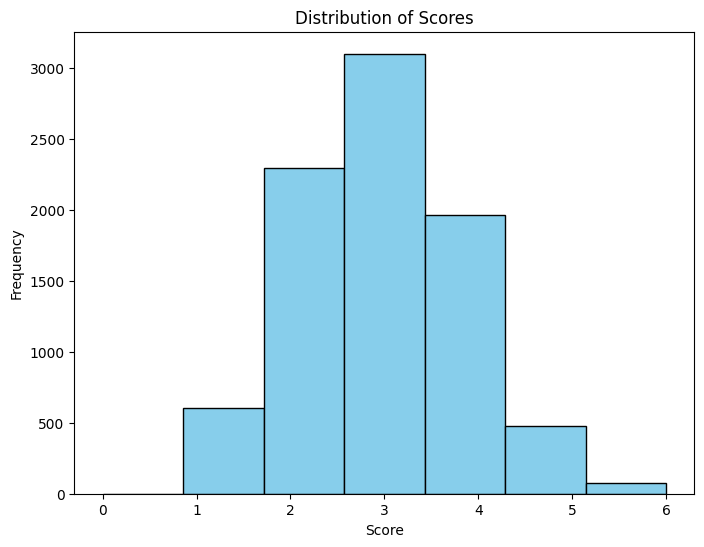

In [91]:
# Visualize distribution of scores
plt.figure(figsize=(8, 6))
plt.hist(y, bins=7, range=(0, y.max()), color='skyblue', edgecolor='black')
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.xticks(range(maxScore + 1))  # Ensure that x-axis shows all scores from 0 to the max score (6)
plt.show()

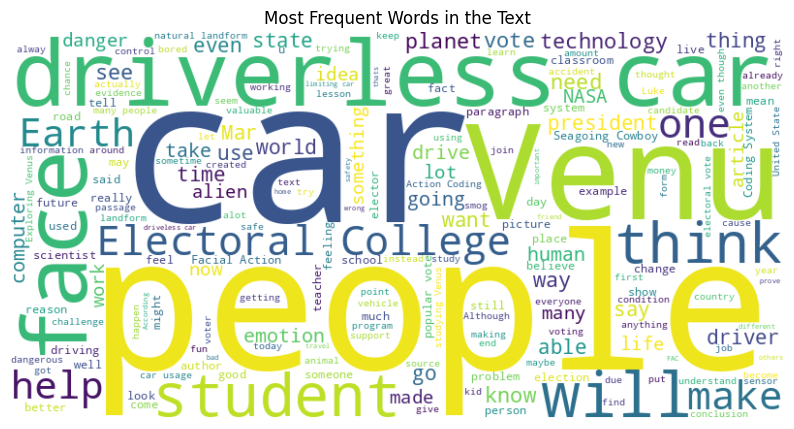

In [69]:
# Visualize the most frequent words
text_data = ' '.join(X)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_data)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Most Frequent Words in the Text")
plt.show()

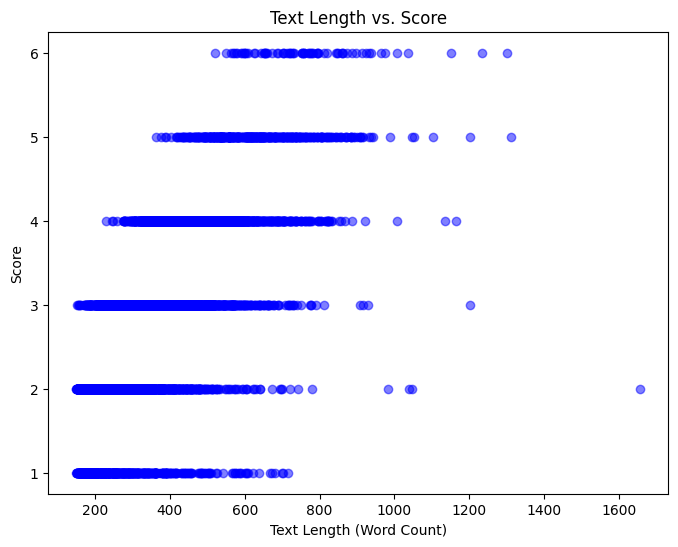

In [70]:
# Visualize length of text vs. score
# Calculate the length of each text (in terms of word count)
text_lengths = X.apply(lambda text: len(text.split()))

# Plot the length of text vs. the score
plt.figure(figsize=(8, 6))
plt.scatter(text_lengths, y, alpha=0.5, color='blue')
plt.title("Text Length vs. Score")
plt.xlabel("Text Length (Word Count)")
plt.ylabel("Score")
plt.show()

In [27]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Train-Validation split (from the original training data)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

In [28]:
# Text preprocessing (tokenization & padding)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)  # Fit tokenizer only on the training data

# Convert texts to sequences (tokenized words)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Padding sequences to ensure uniform input size
# maxlength = 50  #< Maximum length of input sequences
X_train_pad = pad_sequences(X_train_seq)
X_test_pad = pad_sequences(X_test_seq)
X_val_pad = pad_sequences(X_val_seq)

# Convert scores (labels) into numpy array
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

# Check the types and shapes to ensure they are correct
print(f"X_train_pad type: {type(X_train_pad)} | Shape: {X_train_pad.shape}")
print(f"X_test_pad type: {type(X_test_pad)} | Shape: {X_test_pad.shape}")
print(f"y_train type: {type(y_train)} | Shape: {y_train.shape}")
print(f"y_test type: {type(y_test)} | Shape: {y_test.shape}")

X_train_pad type: <class 'numpy.ndarray'> | Shape: (4560, 4714)
X_test_pad type: <class 'numpy.ndarray'> | Shape: (2809, 2363)
y_train type: <class 'numpy.ndarray'> | Shape: (4560,)
y_test type: <class 'numpy.ndarray'> | Shape: (2809,)


In [29]:
# Build the LSTM Model
model = Sequential()

# Embedding Layer: To convert tokens into dense vectors (word embeddings)
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1,  #< vocabulary size
                    output_dim=128)) #< embedding dimension

# LSTM Layer: To process sequences and capture dependencies
model.add(LSTM(64, return_sequences=False))  #< LSTM with 64 units

# Dropout Layer: To prevent overfitting
model.add(Dropout(0.5))

# Dense Layer: To output a probability distribution across possible classes (0-6)
model.add(Dense(maxScore+1, activation='softmax'))

In [30]:
# Compile the model
# Use sparse categorical cross-entropy for multi-class classification
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 4714, 128)           │       4,042,880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 7)                   │             455 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 12,278,231 (46.84 MB)

 Trainable params: 4,092,743 (15.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 8,185,488 (31.23 MB)

In [9]:
# Train the model with train and eval
history = model.fit(X_train_pad, y_train, epochs=10, batch_size=64, validation_data=(X_val_pad, y_val))

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 16s 161ms/step - accuracy: 0.3172 - loss: 1.7093 - val_accuracy: 0.3707 - val_loss: 1.4457
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 17s 157ms/step - accuracy: 0.3547 - loss: 1.4598 - val_accuracy: 0.3620 - val_loss: 1.4244
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.4305 - loss: 1.3386 - val_accuracy: 0.3856 - val_loss: 1.3694
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 157ms/step - accuracy: 0.5278 - loss: 1.1458 - val_accuracy: 0.3944 - val_loss: 1.4156
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - accuracy: 0.6686 - loss: 0.8980 - val_accuracy: 0.3891 - val_loss: 1.5003
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 160ms/step - accuracy: 0.7554 - loss: 0.6871 - val_accuracy: 0.3760 - val_loss: 1.6000
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.8351 - loss: 0.5319 - val_accuracy: 0.3900 - val_loss: 1.8269
Epoch 8/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 158ms/step - accuracy: 0.8864 - loss: 0.3951 - val_accu

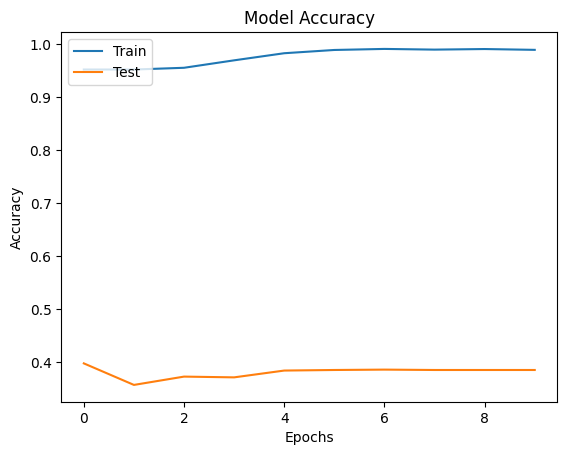

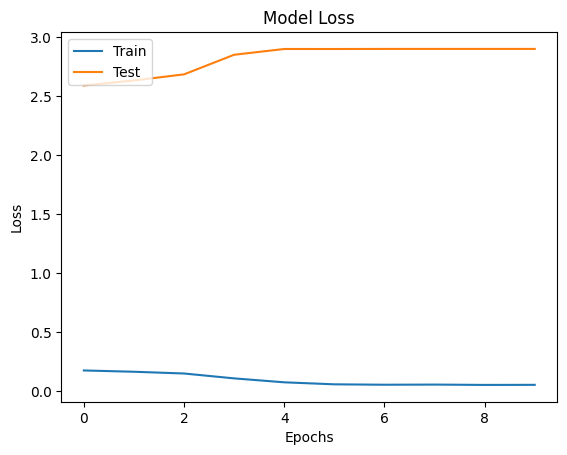

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [12]:
'''
As displayed above, the model's training accuracy is improving signifcantly,
but the validation accuracy is lagging, which could indicate overfitting.
Therefore, further iterative improvements are included below to address this.
'''

"\nAs displayed above, the model's training accuracy is improving signifcantly,\nbut the validation accuracy is lagging, which could indicate overfitting.\nTherefore, further iterative improvements are included below to address this.\n"

In [31]:
'''
Learning Rate Scheduling:
Dynamically adjusting the learning rate can help the model converge more effectively.
For instance, using a learning rate scheduler can help reduce the learning rate as the training progresses.
'''
# Train the model
def scheduler(epoch, lr):
    if epoch > 3:
        return lr * 0.1  #< Decay after 3 epochs
    return lr

lr_scheduler = LearningRateScheduler(scheduler)

history = model.fit(X_train_pad, y_train, epochs=10, batch_size=64,
                    validation_data=(X_test_pad, y_test),
                    callbacks=[lr_scheduler])

Epoch 1/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - accuracy: 0.2764 - loss: 1.7346 - val_accuracy: 0.3702 - val_loss: 1.4742 - learning_rate: 0.0010
Epoch 2/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 23s 209ms/step - accuracy: 0.3400 - loss: 1.4981 - val_accuracy: 0.3699 - val_loss: 1.4485 - learning_rate: 0.0010
Epoch 3/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 18s 172ms/step - accuracy: 0.4127 - loss: 1.3744 - val_accuracy: 0.3571 - val_loss: 1.4415 - learning_rate: 0.0010
Epoch 4/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - accuracy: 0.5608 - loss: 1.1369 - val_accuracy: 0.3507 - val_loss: 1.4960 - learning_rate: 0.0010
Epoch 5/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 171ms/step - accuracy: 0.6930 - loss: 0.8719 - val_accuracy: 0.3535 - val_loss: 1.5687 - learning_rate: 1.0000e-04
Epoch 6/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 172ms/step - accuracy: 0.7068 - loss: 0.8170 - val_accuracy: 0.3621 - val_loss: 1.5672 - learning_rate: 1.0000e-05
Epoch 7/10
72/72 ━━━━━━━━━━━━━━━━━━━━ 21s 172ms/step - accuracy: 0.7233 - 

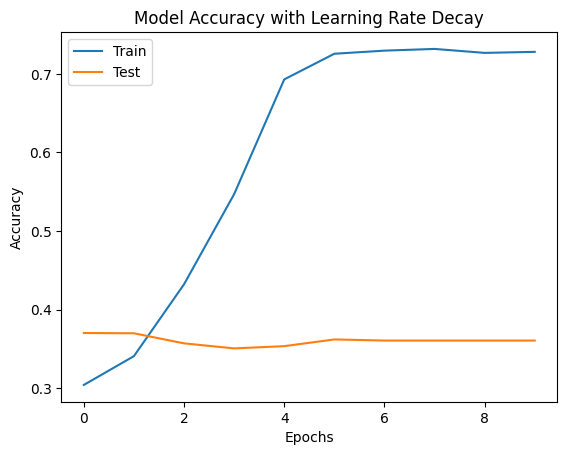

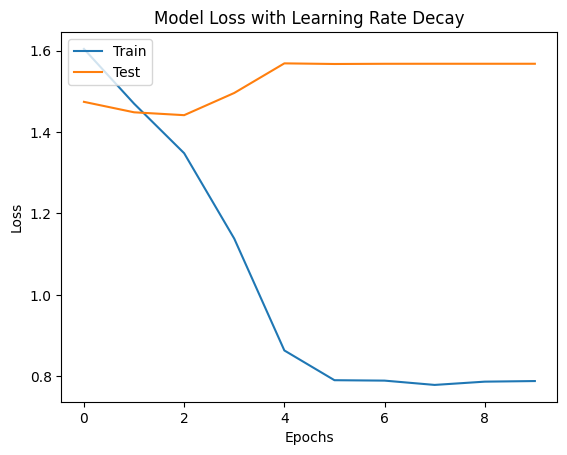

In [32]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy with Learning Rate Decay')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss with Learning Rate Decay')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [15]:
# Evaluation metrics
# Assuming y_pred_probs contains the output of model predictions
y_pred_probs = model.predict(X_test_pad)

# Convert predicted probabilities to class labels
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate metrics
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
fscore_macro = fbeta_score(y_test, y_pred, beta=1, average='macro')

precision_micro = precision_score(y_test, y_pred, average='micro')
recall_micro = recall_score(y_test, y_pred, average='micro')
fscore_micro = fbeta_score(y_test, y_pred, beta=1, average='micro')

precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
fscore_weighted = fbeta_score(y_test, y_pred, beta=1, average='weighted')

accuracy = accuracy_score(y_test, y_pred)

print("Precision (Macro):", precision_macro)
print("Recall (Macro):", recall_macro)
print("F1 Score (Macro):", fscore_macro)
print("Precision (Micro):", precision_micro)
print("Recall (Micro):", recall_micro)
print("F1 Score (Micro):", fscore_micro)
print("Precision (Weighted):", precision_weighted)
print("Recall (Weighted):", recall_weighted)
print("F1 Score (Weighted):", fscore_weighted)
print("Overall Accuracy:", accuracy)

88/88 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step
Precision (Macro): 0.29573581508760566
Recall (Macro): 0.2573651421894449
F1 Score (Macro): 0.26400296809006835
Precision (Micro): 0.38554645781416874
Recall (Micro): 0.38554645781416874
F1 Score (Micro): 0.38554645781416874
Precision (Weighted): 0.3730191565916721
Recall (Weighted): 0.38554645781416874
F1 Score (Weighted): 0.37703300183006944
Overall Accuracy: 0.38554645781416874


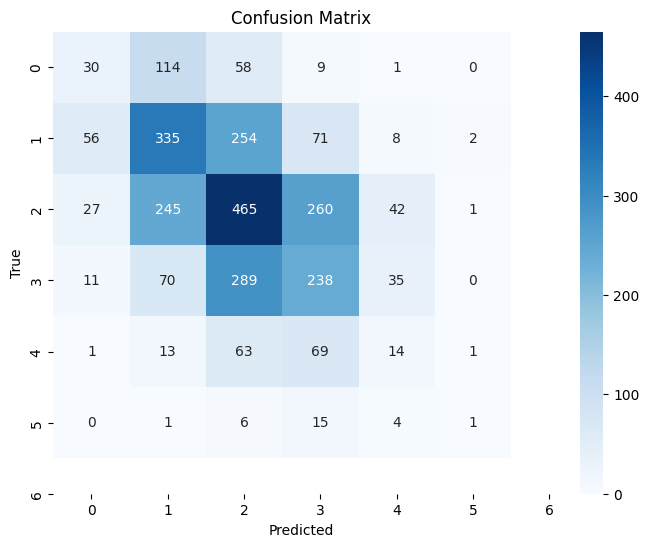

In [16]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(maxScore + 1), yticklabels=range(maxScore + 1))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:1183: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


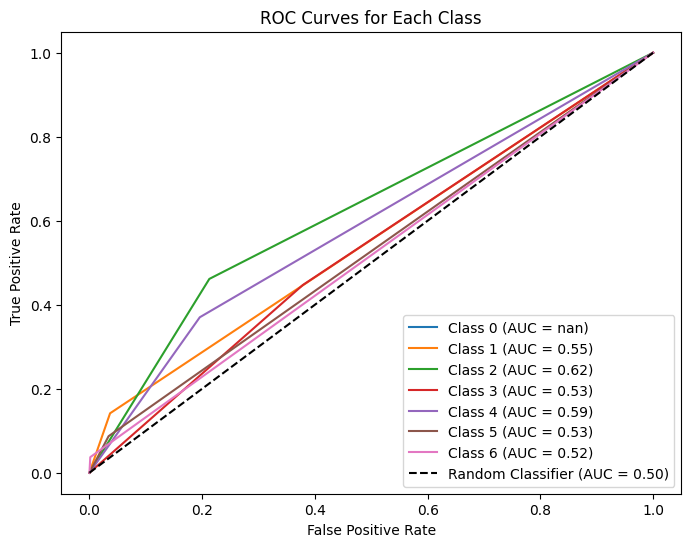

In [17]:
# Binarize the output labels
y_test_binarized = label_binarize(y_test, classes=range(maxScore + 1))
y_pred_binarized = label_binarize(y_pred, classes=range(maxScore + 1))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(maxScore + 1):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(maxScore + 1):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.50)')
plt.title('ROC Curves for Each Class')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [18]:
# Calculate the Quadratic Weighted Kappa
qwk = cohen_kappa_score(y_test, y_pred, weights='quadratic')
print(f"Quadratic Weighted Kappa (QWK): {qwk}")

Quadratic Weighted Kappa (QWK): 0.41340393076209814
